In [1]:
import numpy as np
from time import time
from typing import Optional
from numpy.typing import NDArray
from scipy.sparse import csr_matrix, spmatrix
from scipy.sparse.linalg import spsolve, LinearOperator, cg
from fenics import (
    FunctionSpace, Function, TrialFunction, TestFunction,
    Constant, DirichletBC, dot, grad, dx, ds, assemble,
    as_backend_type, LUSolver, Expression, interpolate
)

from fenics import *
from mesh_utils import get_square_f
import matplotlib.pyplot as plt
from matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [24]:
def progress_bar(step, total_steps, bar_length=30, fill='#', end_text=''):
    """
    Simple progress bar.
    """
    filled = int(bar_length * step / total_steps)
    text = f"[{filled * fill :<{bar_length}}] {step}/{total_steps}"
    end = '\r' if step < total_steps else '\n' 
    print(text + end_text, end=end)


class LowRankSource:
    def __init__(self, V_h: FunctionSpace, sigma: float = 1.0, k: float = 1.0):
        self.V_h = V_h
        self.sigma = sigma
        self.k = k
        self._Uk: Optional[NDArray] = None
        self._Sk: Optional[NDArray] = None
        self._VkT: Optional[NDArray] = None
        self.times = None

        # Setup constants and constant matrices
        self.boundary_dofs = self.get_boundary_dofs()
        self.N = V_h.dim()
        self.N_b = len(self.boundary_dofs)
        self.M_dx = self.get_M_dx()
        self.M_ds = self.get_M_ds()

        # Set up vec to matrix and matrix to vec utils
        coords = self.V_h.tabulate_dof_coordinates()
        self.grid_indices = np.lexsort((coords[:, 0], coords[:, 1]))
        self.dof_indices = np.argsort(self.grid_indices)
        self.grid_dim = int(np.round(np.sqrt(self.N)))

    def matrix_to_vec(self, X):
        return X.flatten()[self.dof_indices]

    def vec_to_matrix(self, x):
        return x[self.grid_indices].reshape((self.grid_dim, self.grid_dim))

    def get_M_dx(self) -> spmatrix:
        """
        Get the mass matrix M_dx as a scipy sparse CSR matrix.
        """
        u = TrialFunction(self.V_h)
        v = TestFunction(self.V_h)
        m = u * v * dx
        
        M = assemble(m)  # Assemble FEniCS matrix
        mat = as_backend_type(M).mat()  # Extract PETSc matrix
        
        # Construct sparse csr matrix
        indptr, indices, data = mat.getValuesCSR()
        return csr_matrix((data, indices, indptr))

    def get_M_ds(self) -> spmatrix:
        """
        Get the boundary mass matrix M_ds as a scipy sparse CSR matrix.
        """
        u = TrialFunction(self.V_h)
        v = TestFunction(self.V_h)
        m_ds = u * v * ds 
        
        M_boundary = assemble(m_ds)
        mat = as_backend_type(M_boundary).mat()
        indptr, indices, data = mat.getValuesCSR()

        M_ds = csr_matrix((data, indices, indptr))
        return M_ds[self.boundary_dofs, :][:, self.boundary_dofs]

    def get_boundary_dofs(self) -> NDArray:
        """
        Given a FunctionSpace V_h, return the id's of the boundary nodes/dofs.
        """
        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(self.V_h, Constant(0.0), boundary)
        bc_dict = bc.get_boundary_values()
        return np.array(sorted(bc_dict.keys()), dtype=int)
 
    def gradient_descent(
            self,
            K: NDArray,
            y: NDArray,
            r_s: int,
            w: NDArray,
            lambda_: float = 0.01,
            alpha: float = 1,
            max_iter: int = 100,
            initial_matrices: str = 'random'
        ) -> Function:
        n = int(np.sqrt(self.N))  # N = n^2

        if initial_matrices == 'random':
            P = np.random.randn(n, r_s) * 0.01
            Q = np.random.randn(n, r_s) * 0.01
        elif initial_matrices == 'tikhonov':
            P, Q = self._initialize_P_and_Q(K, y, r_s, w, lambda_)
        else:
            raise ValueError(f"Unknown initial_matrix: {initial_matrices}")

        for i in range(max_iter):
            X = P @ Q.T
            x = self.matrix_to_vec(X)
            
            # Compute the gradient
            grad_data = K.T @ (self.M_ds @ (K @ x - y))
            grad_reg = lambda_ * (w * (self.M_dx @ (w * x)))
            grad_Phi = grad_data + grad_reg

            # Factor gradients
            G = self.vec_to_matrix(grad_Phi)
            grad_P_Phi = G @ Q
            grad_Q_Phi = G.T @ P

            # Gradient descent
            P -= alpha * grad_P_Phi / (np.linalg.norm(grad_P_Phi) + 1e-9)
            Q -= alpha * grad_Q_Phi / (np.linalg.norm(grad_Q_Phi) + 1e-9)

            if (not i % 50) or (i + 1 == max_iter):
                progress_bar(i + 1, max_iter)
        
        # Construct final solution
        x = self.matrix_to_vec(P @ Q.T)
        f = Function(self.V_h)
        f.vector()[:] = x
        return f

    def _initialize_P_and_Q(self, K, y, r_s, w, lambda_):
        N = self.N
        n = int(np.sqrt(N))

        # Linear operator for CG
        def matvec_A(x):
            r1 = K.T @ (self.M_ds @ (K @ x))
            Wx = w * x
            r2 = w * (self.M_dx @ Wx)
            return r1 + lambda_ * r2

        A_op = sp.sparse.linalg.LinearOperator((N, N), matvec=matvec_A)
        b = K.T @ (self.M_ds @ y)
        
        # Solve iteratively
        x_lambda, info = sp.sparse.linalg.cg(A_op, b, rtol=1e-6, maxiter=500)
        X_lambda = self.vec_to_matrix(x_lambda)

        # Randomized low-rank SVD for speed
        from rsvd import rsvd
        U, S, Vt = rsvd(X_lambda, k=r_s)
        Sigma_sqrt = np.diag(np.sqrt(S))
        P0 = U @ Sigma_sqrt
        Q0 = Vt.T @ Sigma_sqrt
        return P0, Q0

In [25]:
mesh = UnitSquareMesh(64, 64)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
f = get_square_f(V_h, 0.65, 0.65)
x = f.vector().get_local()
y = rsvd.apply_K(x)

U, S, VT = rsvd.mf_rsvd(k=5)
K = U @ np.diag(S) @ VT
W_diag = get_approximate_W(VT.T, rsvd.M_dx)

lrs = LowRankSource(V_h)

[##############################] 50000/50000


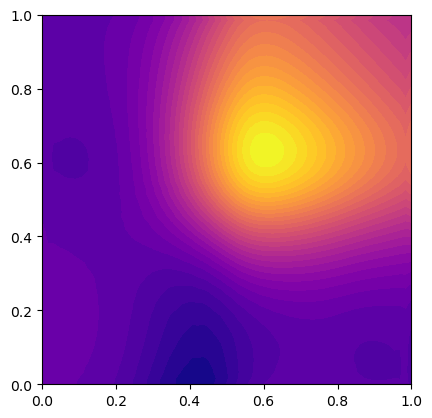

In [32]:
f = lrs.gradient_descent(K, y,
    r_s=2,
    w=W_diag,
    alpha=0.25,
    lambda_=1e-3,
    max_iter=50000)
plot(f, cmap='plasma');